In [119]:
# We recommend using these utils.
# https://google.github.io/mediapy/mediapy.html
# https://einops.rocks/
!pip install mediapy einops --quiet

In [120]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import os
from torchvision.utils import make_grid
import torch.nn.functional as F

device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

In [44]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down_conv(x)


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x):
        return self.up_conv(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Sequential(
            nn.AvgPool2d(kernel_size=7),
            nn.GELU()
        )

    def forward(self, x):
        return self.flatten(x)


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
      super().__init__()
      self.unflatten = nn.Sequential(
          nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7, stride=7, padding=0),
          nn.BatchNorm2d(in_channels),
          nn.GELU()
    )
    def forward(self, x):
        return self.unflatten(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_block(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_block = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down_block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_block = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.up_block(x)

In [31]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        
        # Encoder path
        self.conv_block1 = ConvBlock(in_channels, num_hiddens)
        self.down_block1 = DownBlock(num_hiddens, num_hiddens)
        self.down_block2 = DownBlock(num_hiddens, 2*num_hiddens)
        
        # Bottleneck
        self.flatten = Flatten()
        self.unflatten = Unflatten(2*num_hiddens)
        
        # Decoder path
        self.up_block2 = UpBlock(4*num_hiddens, num_hiddens)  # 4*num_hiddens due to concat
        self.up_block1 = UpBlock(2*num_hiddens, num_hiddens)  # 2*num_hiddens due to concat
        
        # Final layers
        self.final_conv_block = ConvBlock(num_hiddens * 2, num_hiddens)  
        self.output_conv = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)  


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x1 = self.conv_block1(x)  # 28x28
        x2 = self.down_block1(x1)  # 14x14
        x3 = self.down_block2(x2)  # 7x7
        
        x4 = self.flatten(x3)  # 1x1
        x4 = self.unflatten(x4)  # 7x7
        
        x5 = torch.cat([x4, x3], dim=1)
        
        x6 = self.up_block2(x5)
        x6 = torch.cat([x6, x2], dim=1)
        
        x7 = self.up_block1(x6)
        x7 = torch.cat([x7, x1], dim=1)
        
        x7 = self.final_conv_block(x7) 
        out = self.output_conv(x7)
        
        return out

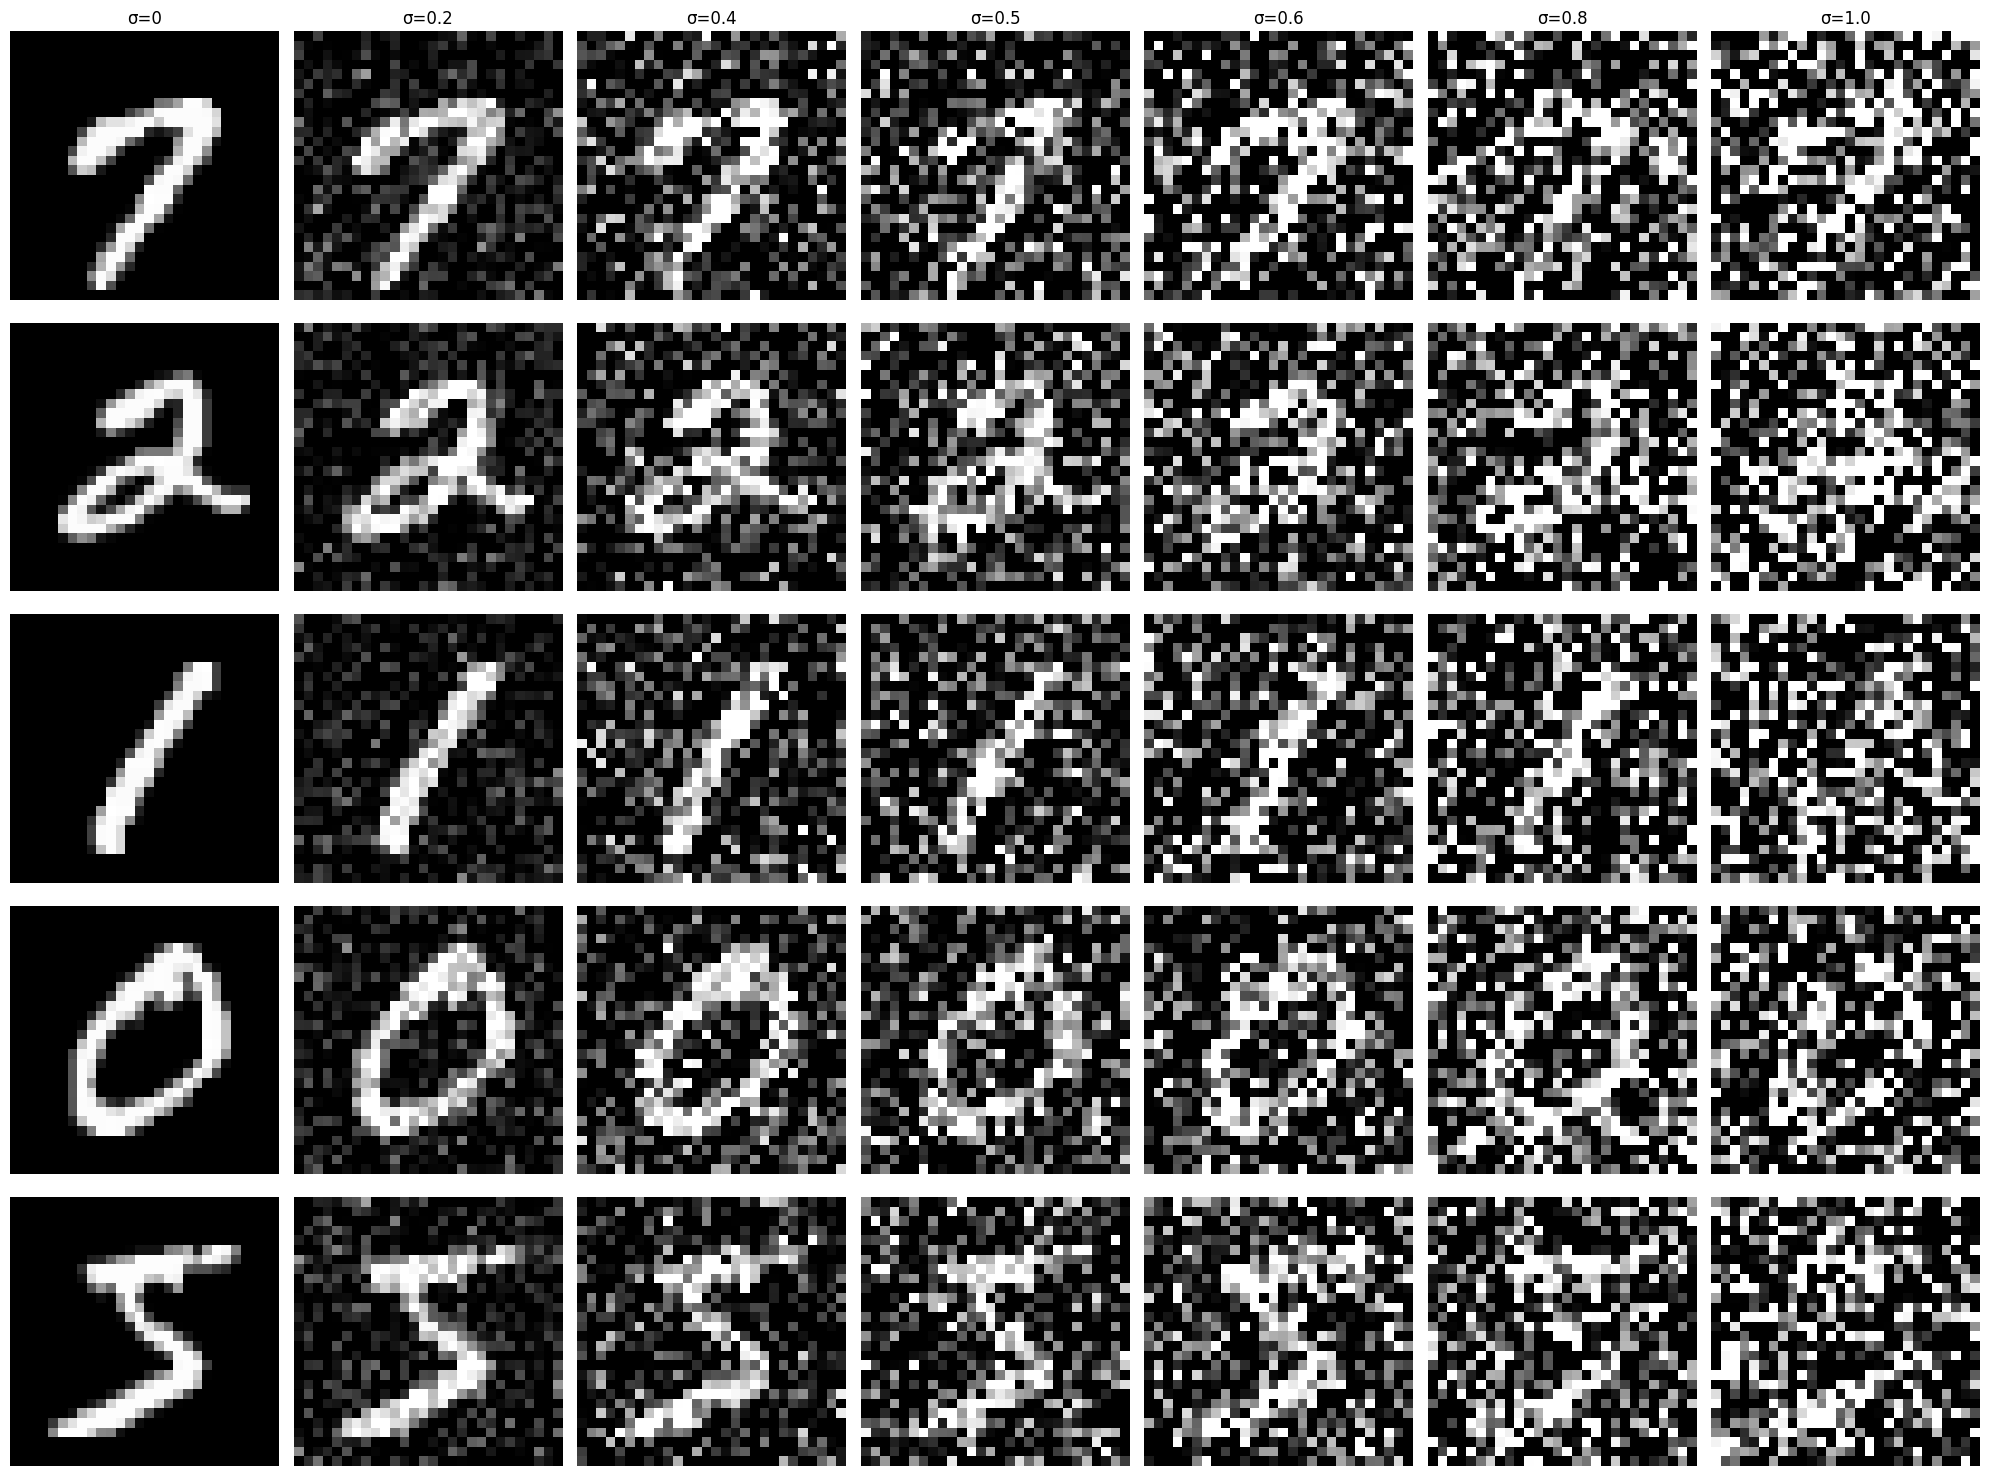

In [32]:
def add_gaussian_noise(x: torch.Tensor, sigma: float) -> torch.Tensor:
    noise = torch.randn_like(x) * sigma
    return torch.clamp(x + noise, 0, 1)

transform = ToTensor()
dataset = MNIST('./data', train=True, download=True, transform=transform)

sigmas = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
target_digits = [7, 2, 1, 0, 5]

fig, axes = plt.subplots(len(target_digits), len(sigmas), figsize=(20, 15))

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

digit_examples = {}
for img, label in dataloader:
    if label.item() in target_digits and label.item() not in digit_examples:
        digit_examples[label.item()] = img.squeeze()
    if len(digit_examples) == len(target_digits):
        break

for row, digit in enumerate(target_digits):
    img = digit_examples[digit]
    for col, sigma in enumerate(sigmas):
        noisy = add_gaussian_noise(img, sigma)
        axes[row, col].imshow(noisy.squeeze(), cmap='gray')
        if row == 0:
            axes[row, col].set_title(f'σ={sigma}')
        if col == 0:
            axes[row, col].set_ylabel(f'Digit {digit}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('pt2/gaussian_noise_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Resumed from epoch {start_epoch}")
        return start_epoch, loss
    return 0, None

def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir='checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pt')
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")

def get_dataloaders(batch_size: int = 256):
    transform = ToTensor()
    train_dataset = MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = MNIST('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def visualize_results(model, test_loader, epoch, sigma=0.5, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images = images[:num_samples].to(device)
        noisy_images = add_gaussian_noise(images, sigma)
        denoised_images = model(noisy_images)

        for idx in range(num_samples):
            axes[idx, 0].imshow(images[idx].cpu().squeeze(), cmap='gray')
            axes[idx, 0].set_title('Original')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(noisy_images[idx].cpu().squeeze(), cmap='gray')
            axes[idx, 1].set_title(f'Noisy (σ={sigma})')
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(denoised_images[idx].cpu().squeeze(), cmap='gray')
            axes[idx, 2].set_title('Denoised')
            axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(f'denoising_results_epoch_{epoch}.png')
    plt.close()

In [34]:
def train_model(model, train_loader, test_loader, num_epochs=5, sigma=0.5, resume_path=None):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()
    
    start_epoch = 0
    if resume_path:
        start_epoch, _ = load_checkpoint(model, optimizer, resume_path)
    
    step_losses = []
    total_steps = 0
    
    for epoch in range(start_epoch + 1, num_epochs + 1):
        model.train()
        epoch_loss = 0
        
        for batch, (images, _) in enumerate(train_loader):
            total_steps += 1
            images = images.to(device)
            noisy_images = add_gaussian_noise(images, sigma)
            
            optimizer.zero_grad()
            denoised_images = model(noisy_images)
            loss = criterion(denoised_images, images)
            
            loss.backward()
            optimizer.step()
            
            step_losses.append(loss.item())
            epoch_loss += loss.item()
            
            if total_steps % 100 == 0:
                print(f'Step {total_steps}, Loss: {loss.item():.6f}')
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}")
        
        save_checkpoint(model, optimizer, epoch, avg_epoch_loss)
        
        if epoch in [1, num_epochs]:
            visualize_results(model, test_loader, epoch, sigma)
    
    plt.figure(figsize=(10, 6))
    
    steps = range(1, len(step_losses) + 1)
    plt.semilogy(steps, step_losses, 'b-', linewidth=0.5)
    
    plt.grid(True, linestyle='--', alpha=0.7, which='both')  # Grid lines for both major and minor ticks
    plt.xlabel('Training Steps')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Loss Over Time (Log Scale)')
    
    plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.set_minor_formatter(plt.ScalarFormatter(useMathText=True))
    
    plt.tight_layout()
    plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
    plt.close()


In [18]:
train_loader, test_loader = get_dataloaders(batch_size=256)

model = UnconditionalUNet(in_channels=1, num_hiddens=128)

checkpoint_dir = 'checkpoints'
resume_path = None
if os.path.exists(checkpoint_dir):
  checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_')])
  if checkpoints:
      resume_path = os.path.join(checkpoint_dir, checkpoints[-1])

train_model(model, train_loader, test_loader, num_epochs=5, sigma=0.5, resume_path=resume_path)

Epoch 1/5, Average Loss: 0.028886
Epoch 2/5, Average Loss: 0.011714
Epoch 3/5, Average Loss: 0.010124
Epoch 4/5, Average Loss: 0.009420
Epoch 5/5, Average Loss: 0.009036


In [20]:
sigmas=[0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
num_samples=5

model.eval()
    
sevens = []
for images, labels in test_loader:
    mask = labels == 7
    sevens.extend(images[mask][:num_samples])

sevens = sevens[:num_samples]
images = torch.stack(sevens).to(device)

fig, axes = plt.subplots(len(sigmas), 2, figsize=(8, 4*len(sigmas)))

with torch.no_grad():
    # Use the first seven for all noise levels
    clean_image = images[0]
    
    for row, sigma in enumerate(sigmas):
        noisy_image = add_gaussian_noise(clean_image.unsqueeze(0), sigma=sigma)
        axes[row, 0].imshow(noisy_image.cpu().squeeze(), cmap='gray')
        axes[row, 0].set_title(f'Noisy (σ={sigma})')
        axes[row, 0].axis('off')
        
        denoised_image = model(noisy_image)
        axes[row, 1].imshow(denoised_image.cpu().squeeze(), cmap='gray')
        axes[row, 1].set_title('Denoised')
        axes[row, 1].axis('off')

plt.suptitle('Denoising Results for Different Noise Levels', y=1.02)
plt.tight_layout()
plt.savefig('denoising_comparison_noise_levels.png', dpi=300, bbox_inches='tight')
plt.close()

Part 2: time conditioned

In [121]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        return x


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels

        self.conv_block1 = ConvBlock(in_channels, num_hiddens)
        self.down_block1 = DownBlock(num_hiddens, num_hiddens)
        self.down_block2 = DownBlock(num_hiddens, 2*num_hiddens)
        
        self.flatten = Flatten()
        self.unflatten = Unflatten(2*num_hiddens)
        
        self.fc1_t = FCBlock(1, 2*num_hiddens)  # For unflatten output
        self.fc2_t = FCBlock(1, num_hiddens)    # For first upblock
        
        self.up_block2 = UpBlock(4*num_hiddens, num_hiddens)  # 4D due to concat
        self.up_block1 = UpBlock(2*num_hiddens, num_hiddens)  # 2D due to concat
        
        self.final_conv_block = ConvBlock(2*num_hiddens, num_hiddens)
        self.output_conv = nn.Conv2d(num_hiddens, 1, kernel_size=3, stride=1, padding=1)  


    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."

        x1 = self.conv_block1(x)        
        x2 = self.down_block1(x1)       
        x3 = self.down_block2(x2)       
        
        x4 = self.flatten(x3)           
        x4 = self.unflatten(x4)         
        
        t = t.view(-1, 1) 
        t1 = self.fc1_t(t)  
        t2 = self.fc2_t(t) 
        
        x4 = x4 + t1.view(-1, t1.size(1), 1, 1)
        
        x4 = torch.cat([x4, x3], dim=1)  
        x5 = self.up_block2(x4)       
        
        x5 = x5 + t2.view(-1, t2.size(1), 1, 1)
        
        x5 = torch.cat([x5, x2], dim=1) 
        x6 = self.up_block1(x5)     
        x6 = torch.cat([x6, x1], dim=1)  
        
        x7 = self.final_conv_block(x6)
        out = self.output_conv(x7)
        
        return out

In [125]:
def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."    
    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    
    return {
        "betas": betas,
        "alphas": alphas,
        "alpha_bars": alpha_bars
    }

def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper."""
    unet.train()
    batch_size = x_0.shape[0]
    t = torch.randint(0, num_ts, (batch_size,), device=x_0.device)
    
    noise = torch.randn_like(x_0)
    alpha_bar_t = ddpm_schedule["alpha_bars"][t].view(-1, 1, 1, 1)
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    predicted_noise = unet(x_t, t.float() / num_ts)
    loss = nn.MSELoss()(predicted_noise, noise)
    
    return loss

@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2 of the DDPM paper with classifier-free guidance.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    torch.manual_seed(seed)
    
    batch_size = 1
    channels = unet.in_channels
    device = next(unet.parameters()).device
    
    x = torch.randn(batch_size, channels, *img_wh, device=device)
    
    for t in range(num_ts - 1, -1, -1):
        t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
        predicted_noise = unet(x, t_tensor.float() / num_ts)
        
        alpha = ddpm_schedule["alphas"][t]
        alpha_bar = ddpm_schedule["alpha_bars"][t]
        beta = ddpm_schedule["betas"][t]
        
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * predicted_noise) + torch.sqrt(beta) * noise
    
    return x

In [126]:
model = TimeConditionalUNet(
        in_channels=1,
        num_classes=1,
        num_hiddens=64).to(device)

train_loader, test_loader = get_dataloaders(batch_size=128)

num_epochs=20
T=300

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ddpm_schedule(beta1=1e-4, beta2=0.02, num_ts=1000)
criterion = nn.MSELoss()

beta = torch.linspace(0.0001, 0.02, T).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)


step_losses = []
total_steps = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    
    for batch, (x0, _) in enumerate(train_loader):
        total_steps += 1
        x0 = x0.to(device)  
        batch_size = x0.shape[0]
        
        t = torch.randint(0, T, (batch_size,), device=device)
        
        epsilon = torch.randn_like(x0)
        
        alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
        xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * epsilon
        
        t_normalized = t.float() / T
        predicted_noise = model(xt, t_normalized)
        
        optimizer.zero_grad()
        loss = criterion(predicted_noise, epsilon)
        loss.backward()
        optimizer.step()
        
        step_losses.append(loss.item())
        epoch_loss += loss.item()
        
        if batch % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch}, Loss: {loss.item():.6f}')
    
    scheduler.step()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}")
    
    save_checkpoint(model, optimizer, epoch, avg_epoch_loss)


Epoch 1, Batch 0, Loss: 1.117453


KeyboardInterrupt: 

In [70]:
plt.figure(figsize=(10, 6))
steps = range(1, len(step_losses) + 1)
plt.semilogy(steps, step_losses, 'b-', linewidth=0.5, alpha=0.5, label='Step Loss')
plt.grid(True, linestyle='--', alpha=0.7, which='both')
plt.xlabel('Training Steps')
plt.ylabel('Loss (log scale)')
plt.title('Diffusion Model Training Loss')
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(plt.ScalarFormatter())
plt.tight_layout()
plt.savefig('diffusion_training_loss.png', dpi=300, bbox_inches='tight')
plt.close()

In [123]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, c, img_wh, self.num_ts, guidance_scale, seed
        )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


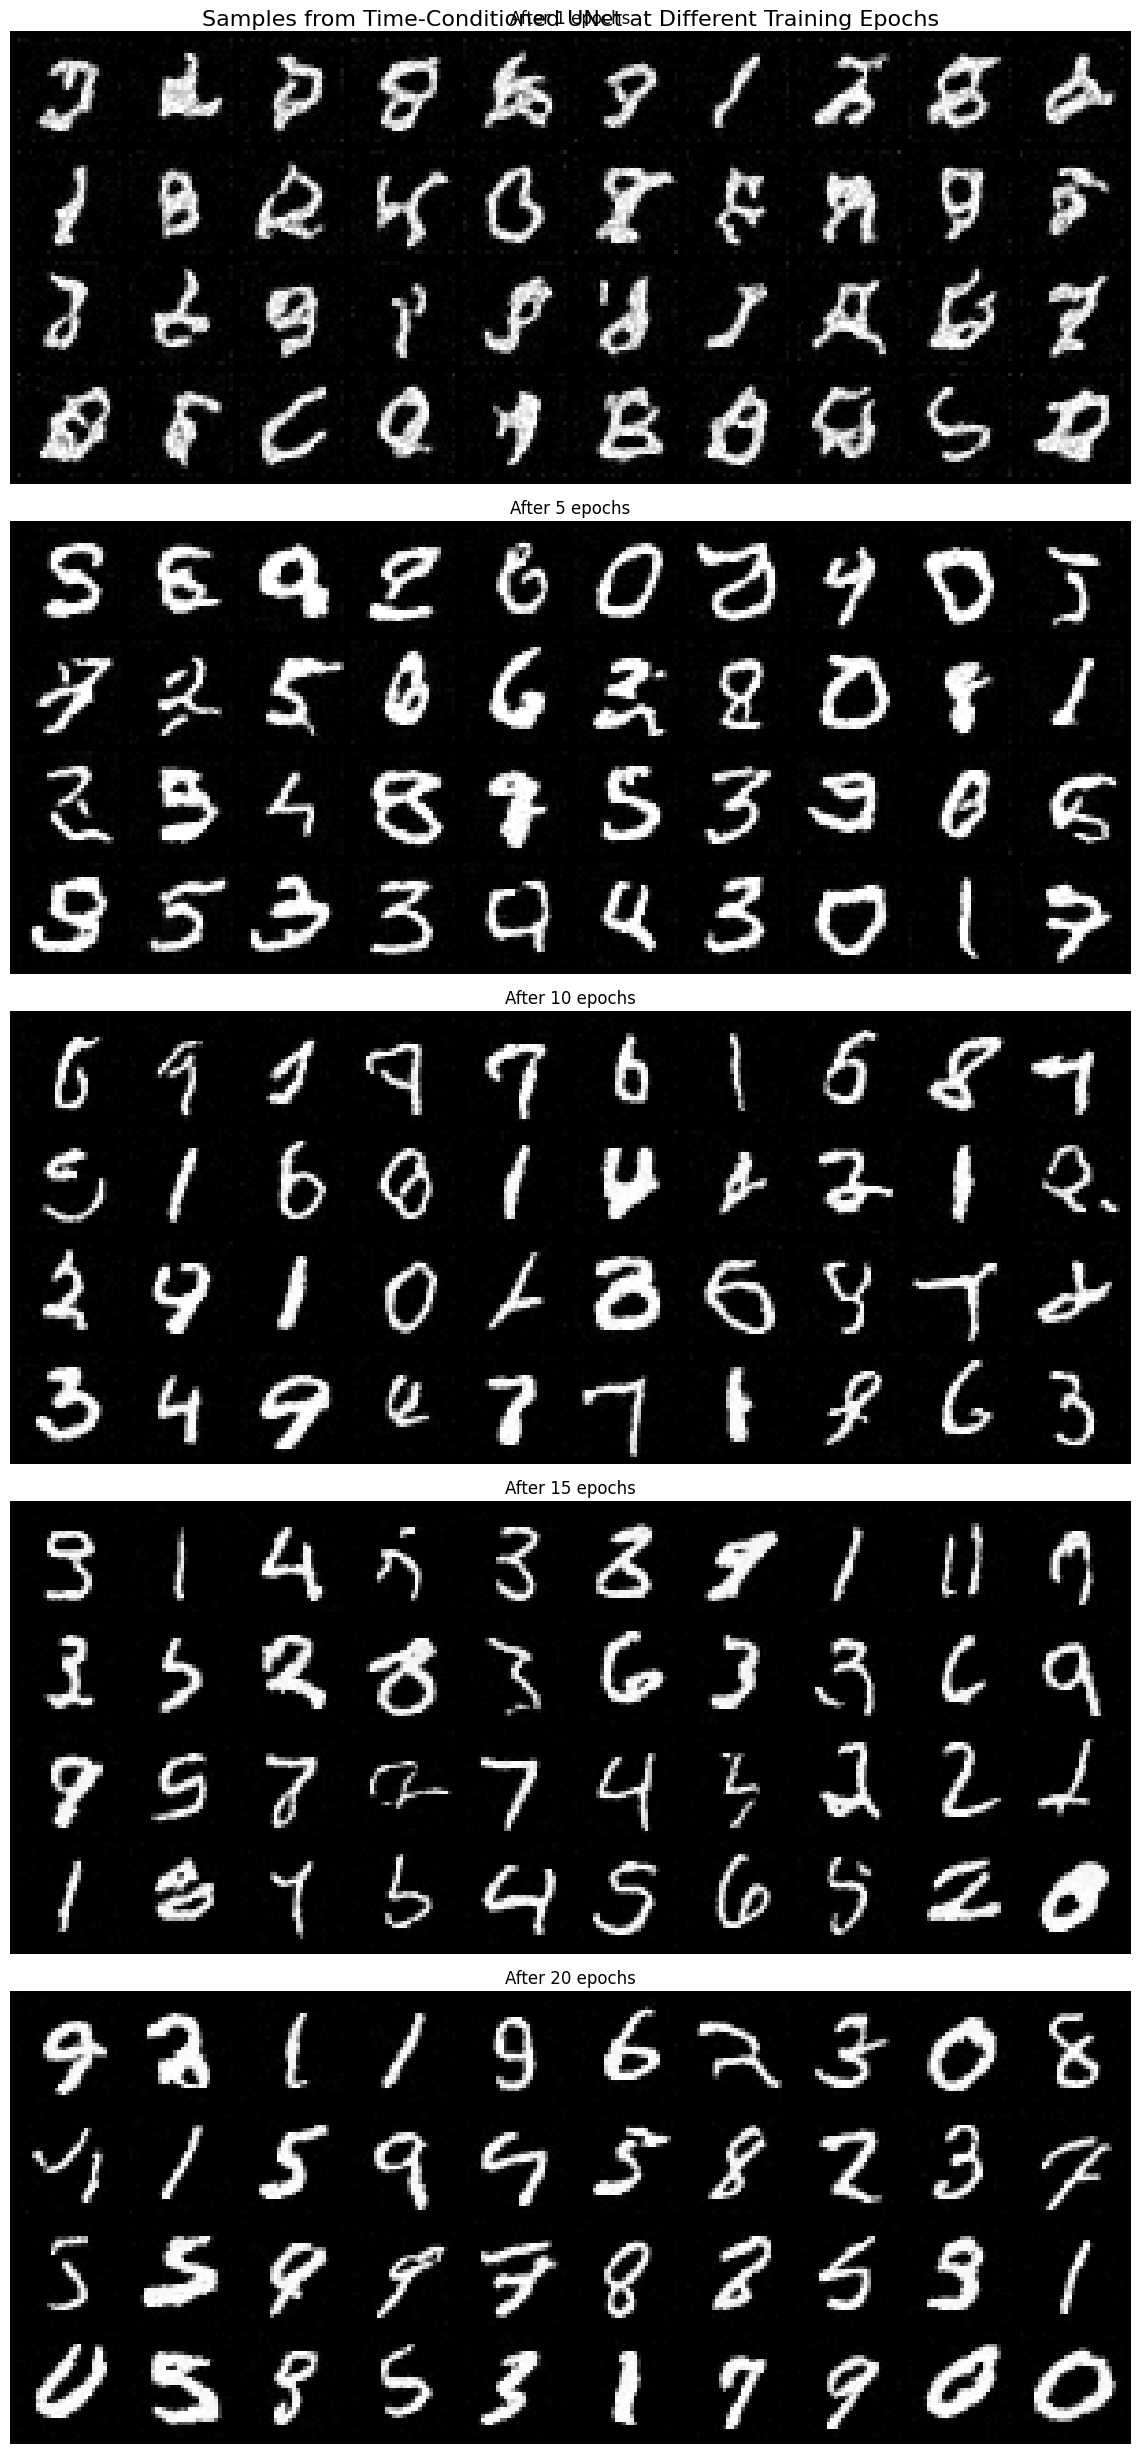

In [73]:
def generate_samples(model, ddpm_schedule_func, num_samples, img_size, num_ts, device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    model.eval()
    with torch.no_grad():
        schedule = ddpm_schedule_func(beta1=1e-4, beta2=0.02, num_ts=num_ts)
        samples = ddpm_sample(
            model,
            schedule,
            img_size,
            num_ts,
            num_samples=num_samples,
            seed=torch.randint(0, 10000, (1,)).item()
        )
    return samples

# Load models for different epochs
epochs = [1, 5, 10, 15, 20]
models = {}
for epoch in epochs:
    model = TimeConditionalUNet(in_channels=1, num_classes=1, num_hiddens=64).to(device)
    checkpoint = torch.load(f'checkpoints/checkpoint_epoch_{epoch}.pt', weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    models[epoch] = model

# Generate samples
num_samples = 40  # 4x10 grid
samples = {}
for epoch in epochs:
    samples[epoch] = generate_samples(models[epoch], ddpm_schedule, num_samples, img_size=(28, 28), num_ts=300, device=device)

# Visualize samples
fig, axes = plt.subplots(5, 1, figsize=(20, 25))
fig.suptitle("Samples from Time-Conditioned UNet at Different Training Epochs", fontsize=16)

for idx, epoch in enumerate(epochs):
    ax = axes[idx]
    grid = make_grid(samples[epoch], nrow=10).permute(1, 2, 0).cpu()
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"After {epoch} epochs")
    ax.axis('off')

plt.tight_layout()
plt.show()

pt2: class conditioned

In [128]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_hiddens = num_hiddens

        self.conv_block1 = ConvBlock(in_channels, num_hiddens)
        self.down_block1 = DownBlock(num_hiddens, num_hiddens)
        self.down_block2 = DownBlock(num_hiddens, 2*num_hiddens)
        
        self.flatten = Flatten()
        self.unflatten = Unflatten(2*num_hiddens)
        
        self.fc1_t = FCBlock(1, 2*num_hiddens)
        self.fc2_t = FCBlock(1, num_hiddens)
        self.fc1_c = FCBlock(num_classes, 2*num_hiddens)
        self.fc2_c = FCBlock(num_classes, num_hiddens)
        
        # Decoder path
        self.up_block2 = UpBlock(4*num_hiddens, num_hiddens)
        self.up_block1 = UpBlock(2*num_hiddens, num_hiddens)
        
        self.final_conv_block = ConvBlock(2*num_hiddens, num_hiddens)
        self.output_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        
        x1 = self.conv_block1(x)        
        x2 = self.down_block1(x1)       
        x3 = self.down_block2(x2)       
        
        x4 = self.flatten(x3)           
        x4 = self.unflatten(x4)         
        
        t = t.view(-1, 1)
        t1 = self.fc1_t(t)  
        t2 = self.fc2_t(t) 
        
        c_one_hot = F.one_hot(c, num_classes=self.num_classes).float()
        if mask is not None:
            c_one_hot = c_one_hot * mask.unsqueeze(1)
        
        c1 = self.fc1_c(c_one_hot)  
        c2 = self.fc2_c(c_one_hot) 
        
        x4 = c1.view(-1, c1.size(1), 1, 1) * x4 + t1.view(-1, t1.size(1), 1, 1)
        
        x4 = torch.cat([x4, x3], dim=1)
        x5 = self.up_block2(x4)
        
        x5 = c2.view(-1, c2.size(1), 1, 1) * x5 + t2.view(-1, t2.size(1), 1, 1)
        
        x5 = torch.cat([x5, x2], dim=1)
        x6 = self.up_block1(x5)
        x6 = torch.cat([x6, x1], dim=1)
        
        x7 = self.final_conv_block(x6)
        out = self.output_conv(x7)
        
        return out

In [116]:
model = ClassConditionalUNet(
    in_channels=1,
    num_classes=10,  
    num_hiddens=64
).to(device)

train_loader, test_loader = get_dataloaders(batch_size=128)

num_epochs = 20
T = 300
p_uncond = 0.1  # Probability of setting class condition to zero-vector

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
criterion = nn.MSELoss()

beta = torch.linspace(0.0001, 0.02, T).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

step_losses = []
total_steps = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0
    
    for batch, (x0, c) in enumerate(train_loader):
        total_steps += 1
        x0 = x0.to(device)
        c = c.to(device)
        batch_size = x0.shape[0]
        
        t = torch.randint(0, T, (batch_size,), device=device)
        
        epsilon = torch.randn_like(x0)
        
        alpha_bar_t = alpha_bar[t].view(-1, 1, 1, 1)
        xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * epsilon
        
        mask = torch.rand(batch_size, device=device) >= p_uncond
        
        t_normalized = t.float() / T
        predicted_noise = model(xt, c, t_normalized, mask)
        
        optimizer.zero_grad()
        loss = criterion(predicted_noise, epsilon)
        loss.backward()
        optimizer.step()
        
        step_losses.append(loss.item())
        epoch_loss += loss.item()
        
        if batch % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch}, Loss: {loss.item():.6f}')
    
    scheduler.step()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}")
    
    save_checkpoint(model, optimizer, epoch, avg_epoch_loss)

Epoch 1, Batch 0, Loss: 1.160896
Epoch 1, Batch 100, Loss: 0.999969
Epoch 1, Batch 200, Loss: 1.001609
Epoch 1, Batch 300, Loss: 0.991225
Epoch 1, Batch 400, Loss: 0.979833
Epoch 1/20, Average Loss: 0.995453
Checkpoint saved: checkpoints/checkpoint_epoch_1.pt
Epoch 2, Batch 0, Loss: 0.967211
Epoch 2, Batch 100, Loss: 0.960702
Epoch 2, Batch 200, Loss: 0.941605
Epoch 2, Batch 300, Loss: 0.927102
Epoch 2, Batch 400, Loss: 0.920875
Epoch 2/20, Average Loss: 0.939822
Checkpoint saved: checkpoints/checkpoint_epoch_2.pt
Epoch 3, Batch 0, Loss: 0.925694
Epoch 3, Batch 100, Loss: 0.922630
Epoch 3, Batch 200, Loss: 0.910330
Epoch 3, Batch 300, Loss: 0.901950
Epoch 3, Batch 400, Loss: 0.906187
Epoch 3/20, Average Loss: 0.909661
Checkpoint saved: checkpoints/checkpoint_epoch_3.pt
Epoch 4, Batch 0, Loss: 0.906966
Epoch 4, Batch 100, Loss: 0.901781
Epoch 4, Batch 200, Loss: 0.900307
Epoch 4, Batch 300, Loss: 0.900636
Epoch 4, Batch 400, Loss: 0.890926
Epoch 4/20, Average Loss: 0.898561
Checkpoint s

In [ ]:
plt.figure(figsize=(10, 6))
steps = range(1, len(step_losses) + 1)
plt.semilogy(steps, step_losses, 'b-', linewidth=0.5, alpha=0.5, label='Step Loss')
plt.grid(True, linestyle='--', alpha=0.7, which='both')
plt.xlabel('Training Steps')
plt.ylabel('Loss (log scale)')
plt.title('Class Conditioned Model Training Loss')
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(plt.ScalarFormatter())
plt.tight_layout()
plt.savefig('class_conditioned_diffusion_training_loss.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
def generate_class_samples(model, ddpm_schedule_func, num_samples_per_class, img_size, num_ts):
    gamma = 0
    model.eval()
    
    with torch.no_grad():
        schedule = ddpm_schedule_func(beta1=1e-4, beta2=0.02, num_ts=num_ts)
        alpha = schedule["alphas"]
        alpha_bar = schedule["alpha_bars"]
        beta = schedule["betas"]
        
        all_samples = []
        
        for class_label in range(10):
            x_t = torch.randn(num_samples_per_class, 1, *img_size).to(device)
            
            c = torch.full((num_samples_per_class,), class_label, 
                         dtype=torch.long, device=device)
            
            for t in range(num_ts - 1, -1, -1):
                t_tensor = torch.full((num_samples_per_class,), t, device=device, dtype=torch.long)
                t_normalized = t_tensor.float() / num_ts
                
                z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
                
                epsilon_uncond = model(x_t, c, t_normalized, mask=torch.zeros_like(t_tensor))
                epsilon_cond = model(x_t, c, t_normalized, mask=torch.ones_like(t_tensor))
                epsilon = epsilon_uncond + gamma * (epsilon_cond - epsilon_uncond)
                
                x_0 = (1 / torch.sqrt(alpha_bar[t])) * (x_t - torch.sqrt(1 - alpha_bar[t]) * epsilon)
                
                if t > 0:
                    x_t = torch.sqrt(alpha_bar[t-1]) * beta[t] / (1 - alpha_bar[t]) * x_0 + torch.sqrt(alpha[t]) * (1 - alpha_bar[t-1]) / (1 - alpha_bar[t]) * x_t + torch.sqrt(beta[t]) * z
                else:
                    x_t = x_0
            
            all_samples.append(x_t)
        
        samples = torch.cat(all_samples, dim=0)
    
    return samples

In [ ]:
epochs = [1, 5, 10, 15, 20]
models = {}
for epoch in epochs:
    model = ClassConditionalUNet(in_channels=1, num_classes=10, num_hiddens=64).to(device)
    checkpoint = torch.load(f'checkpoints/checkpoint_epoch_{epoch}.pt', weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    models[epoch] = model

samples = {}
for epoch in epochs:
    samples[epoch] = generate_class_samples(
        models[epoch], 
        ddpm_schedule, 
         4, 
        img_size=(28, 28), 
        num_ts=300, 
    )



In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(20, 25))
fig.suptitle("Samples from Class-Conditioned UNet at Different Training Epochs", fontsize=16)

for idx, epoch in enumerate(epochs):
    ax = axes[idx]
    grid = make_grid(samples[epoch], nrow=10).permute(1, 2, 0).cpu()
    ax.imshow(grid, cmap='gray')
    ax.set_title(f"After {epoch} epochs")
    ax.axis('off')

plt.tight_layout()
plt.imsave("class_train_loss.png")
plt.show()